### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

In [5]:
data_wine = pd.read_csv(r"C:\Users\Olga\Downloads\winequality-red.csv")
data_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
data_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [7]:
data_wine['fixed acidity']= data_wine['fixed acidity'].astype('float64')
data_wine['volatile acidity']= data_wine['volatile acidity'].astype('float64')
data_wine['citric acid']= data_wine['citric acid'].astype('float64')
data_wine['residual sugar']= data_wine['residual sugar'].astype('float64')
data_wine['chlorides']= data_wine['chlorides'].astype('float64')
data_wine['free sulfur dioxide']= data_wine['free sulfur dioxide'].astype('float64')
data_wine['total sulfur dioxide']= data_wine['total sulfur dioxide'].astype('float64')
data_wine['density']= data_wine['density'].astype('float64')
data_wine['pH']= data_wine['pH'].astype('float64')
data_wine['sulphates']= data_wine['sulphates'].astype('float64')
data_wine['alcohol']= data_wine['alcohol'].astype('float64')
data_wine['quality']= data_wine['quality'].astype('int64')

In [8]:
data_wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [9]:
data_wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [10]:
data_wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Добавим новый столбец "quality_target", значение ячейки будет равнятся 1, если значение в ячейке "quality" >= 6

In [11]:
data_wine['quality_target'] = data_wine['quality'].apply(lambda x: 1 if x >= 6 else 0, 1)

In [12]:
data_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_target
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


In [13]:
data_wine['quality_target'].value_counts()

1    855
0    744
Name: quality_target, dtype: int64

In [14]:
data_wine.columns.tolist()

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'quality_target']

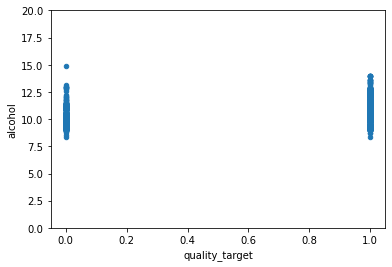

In [15]:
var = 'quality_target'
data = pd.concat([data_wine['alcohol'], data_wine[var]], axis=1)
data.plot.scatter(x=var, y='alcohol', ylim=(0,20));

Из этого графика видно, что чем выше содержание алкоголя, тем выше оценка качества вина.

In [16]:
features = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

target = ['quality_target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_wine[features], data_wine['quality_target'], random_state=0)

In [18]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Больше всего влияют на оценку качества вина показатели содержания алкоголя 'alcohol', летучая кислотность 'volatile аcidity', плотность 'density'.

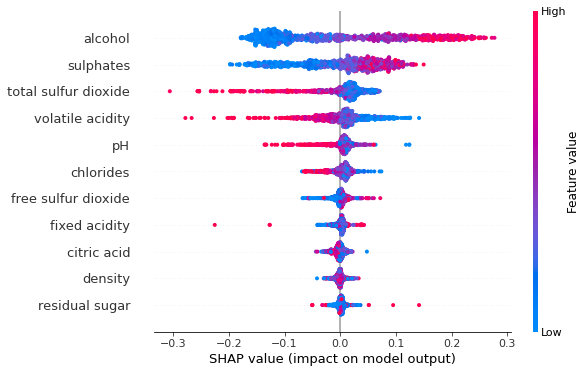

In [19]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

По этому графику можно сделать вывод:
1. Чем выше содержание алкоголя, тем выше оценка вина.
2. Чем больше сульфатов, тем оценка выше.
3. Чем меньше общий показатель диоксида серы 'total sulfur dioxide', тем качество вина ниже.
4. Чем ниже pH, тем оценка ниже.

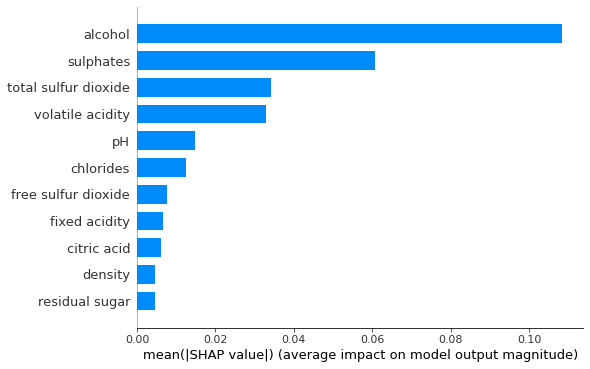

In [20]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Содержание алкоголя 'alcohol' больше всего влияет на оценку качества вина "quality". На втором месте 'sulphates'.
Наименьшее влияение имеют показатели "dencity" и'residual sugar'

SHAP для топ 10%

In [21]:
preds = model.predict(xgboost.DMatrix(X_test))


In [22]:
X_test['preds'] = preds

In [23]:
x_test_sorted = X_test.sort_values(by='preds', ascending=False)

In [24]:

x_test_sorted.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,preds
1026,7.9,0.31,0.32,1.9,0.066,14.0,36.0,0.99364,3.41,0.56,12.6,0.822121
1023,8.2,0.32,0.42,2.3,0.098,3.0,9.0,0.99506,3.27,0.55,12.3,0.822121
794,10.1,0.27,0.54,2.3,0.065,7.0,26.0,0.99531,3.17,0.53,12.5,0.814314
966,9.0,0.38,0.41,2.4,0.103,6.0,10.0,0.99604,3.13,0.58,11.9,0.812857
740,8.3,0.76,0.29,4.2,0.075,12.0,16.0,0.99650,3.45,0.68,11.5,0.811649


In [25]:
x_test_top_ten = x_test_sorted.head(int(X_test.shape[0] * 0.1)).drop(['preds'], axis = 1)

In [26]:

x_test_top_ten.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1026,7.9,0.31,0.32,1.9,0.066,14.0,36.0,0.99364,3.41,0.56,12.6
1023,8.2,0.32,0.42,2.3,0.098,3.0,9.0,0.99506,3.27,0.55,12.3
794,10.1,0.27,0.54,2.3,0.065,7.0,26.0,0.99531,3.17,0.53,12.5
966,9.0,0.38,0.41,2.4,0.103,6.0,10.0,0.99604,3.13,0.58,11.9
740,8.3,0.76,0.29,4.2,0.075,12.0,16.0,0.99650,3.45,0.68,11.5


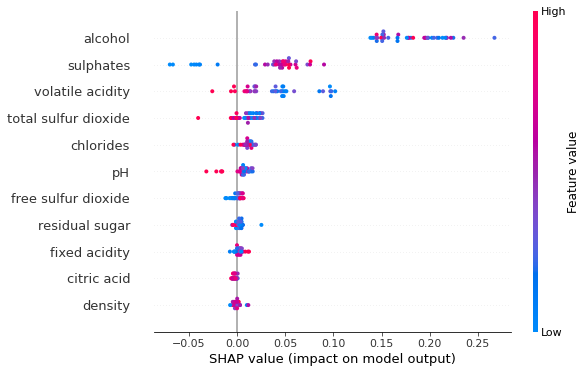

In [27]:
shap_values = explainer.shap_values(x_test_top_ten)
shap.summary_plot(shap_values=shap_values, features=x_test_top_ten)